# Contains steps for analyzing the datasets

In [93]:
import json
import os
import datetime
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = ["sans-serif", "serif"]
rcParams['font.sans-serif'] = ["Trebuchet MS", "Comic Sans MS", 'DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times', 'Palatino', 'Charter', 'serif']
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [88]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/usr/share/fonts/truetype/msttcorefonts/Courier_New_Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Verdana_Bold_Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/timesi.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/verdana.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/georgiaz.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/ariblk.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Georgia_Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Arial_Italic.ttf',
 '/usr/share/fonts/truetype/liberation/Libe

##### Define some constants

In [2]:
_SELECTED = ["easyJet", "Ryanair", "Aer Lingus", "British Airways"]
DATES = [datetime.date(2020, 3, 25), datetime.date(2020, 4, 9)]
#Note: Later, divide periods into <DATES[0], >= DATES[0] && <DATES[1], >=DATES[1]

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
SELECTED_LIST = [x for x in json_list if x["name"] in _SELECTED]


##### Open csv file
Also takes care of timezone in the "created_at" column. 
Plots tweets per day to confirm that it works. 

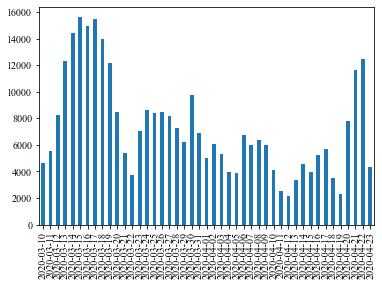

In [3]:
frames = {}
all_data = None
for company in SELECTED_LIST:
    name = company["name"]
    frames[name] = pd.read_csv(os.path.join("csv", name+".csv"), index_col="id")
    frames[name]["created_at"] = pd.to_datetime(frames[name]["created_at"], errors="coerce")
    frames[name]["created_at"] = frames[name]["created_at"].dt.tz_convert(None)
all_data = pd.read_csv(os.path.join("csv", "all_data.csv"), index_col="id")
all_data = all_data[all_data["associated_company"].isin([x["name"] for x in SELECTED_LIST])]
all_data["created_at"] = pd.to_datetime(all_data["created_at"], errors="coerce")
all_data["created_at"] = all_data["created_at"].dt.tz_convert(None)

all_data["created_at"].dt.to_period("D").value_counts().sort_index().plot(kind="bar")
plt.show()

##### Function definitions

In [4]:
#Builds conversation trees with dictionarys.
def build_threads(all_tweets, initial_tweets):
    subthreads = {}
    for index, row in initial_tweets.iterrows():
        subthreads[index] = {
            "screen_name": row["user.screen_name"], 
            "sentiment": row["sentiment"], 
            "created_at": row["created_at"],
            "full_text": row["full_text"],
            "responses": None
        }
        responses = all_tweets[all_tweets["in_reply_to_status_id"] == index]
        if not responses.empty:
            subthreads[index]["responses"] = build_threads(all_tweets, responses)
    return subthreads

# A linked list node.
class Node:
    def __init__(self, _id=None, data=None):
        if data is None:
            self.screen_name = None
            self.created_at = None
            self.sentiment = None
            self.full_text = None
        else: 
            self.screen_name = data["screen_name"]
            self.created_at = data["created_at"]
            self.sentiment = data["sentiment"]
            self.full_text = data["full_text"]
        self.id = _id
        self.next=None
        self.prev=None

# Creates linked lists out of a build_threads() tree, one list per branch. 
def create_llists(threads_dic):
    heads = []
    for k, v in threads_dic.items():
        if v["responses"] is not None:
            children = create_llists(v["responses"])
            for child in children:
                this = Node(k, v)
                child.prev = this
                this.next = child
                heads.append(this)
        else:
            heads.append(Node(k, v))
    return heads

# Calculates reply times for each day.
def calc_reply_times_perday(company_replys, user_tweets):
    reply_times = {}
    for index, row in company_replys.iterrows():
        initial_tweet_id = int(row["in_reply_to_status_id"])
        try:
            initial_tweet = user_tweets.loc[initial_tweet_id]
            date = initial_tweet["created_at"].date()
            if date not in reply_times.keys():
                reply_times[date] = []
            reply_times[date].append(row["created_at"] - initial_tweet["created_at"])
        except KeyError:
            pass
    return reply_times

# Returns a list of sentiments for each day in a dictionary
def calc_sentiment_perday(user_tweets):
    sentiments = {}
    for index, row in user_tweets.iterrows():
        date = row["created_at"].date()
        if date not in sentiments.keys():
                sentiments[date] = []
        sentiments[date].append(row["sentiment"])
    return sentiments

# Returns a data frame with counts per day of the argument data frame.
def calc_tweets_perday(tweets):
    days = {}
    for index, row in tweets.iterrows():
        date = row["created_at"].date()
        if date not in days.keys():
                days[date] = 0
        days[date] += 1
    return pd.DataFrame.from_dict(data=days, orient="index", columns=["tweets_perday"]).sort_index()

##### Generate results

In [76]:
results = {}
for company in SELECTED_LIST:
    name = company["name"]
    handle = company["twitter_handle"]
    tweets = frames[name]
    
    # Data frames for each subset
    from_company = tweets[tweets["user.screen_name"] == handle]
    company_replys = from_company[from_company["in_reply_to_status_id"].notnull()]
    from_user = tweets[tweets["user.screen_name"] != handle]
    
    
    # Create conversations
    conversations = create_llists(build_threads(tweets, from_user[from_user["in_reply_to_status_id"].isnull()]))
    
    # Find user_i -> company -> user_i in conversations.
    # Also count total conversations and conversations with user_i -> company 
    conv_results = {}
    answer_found = False
    prev_head = Node(_id=-1)
    for conv_head in conversations:
        created = conv_head.created_at.date()
        if created not in conv_results:
            conv_results[created] = {"replys": 0, "starters": 0, "one_two_three": 0, "results":[]}
        if prev_head.id != conv_head.id:
            conv_results[created]["starters"] += 1
            answer_found = False
            prev_head = conv_head
        if not answer_found:
            if conv_head.screen_name != handle:
                if conv_head.next is not None and conv_head.next.next is not None:
                    if conv_head.next.screen_name == handle:
                        conv_results[created]["replys"] += 1
                        c_response = conv_head.next
                        if c_response.next.screen_name == conv_head.screen_name:
                            answer_found = True
                            conv_results[created]["results"].append({
                                "sentiment_change": c_response.next.sentiment - conv_head.sentiment,
                                "answer_time": c_response.created_at - conv_head.created_at
                            })
                            conv_results[created]["one_two_three"] += 1
    
    # Add reply_freq to conv_counts as ((user_i -> company) / total) and convert to data frame
    # Keep a conv_result_df for pointwise comparison (due to previous oversight...)
    # Restructure conv_results["results"] into averages for each day and convert to data frame
    conv_results_li = []
    for date in conv_results.keys():
        conv_results_li.append(pd.DataFrame(conv_results[date]["results"]))
        conv_results[date]["reply_freq"] = conv_results[date]["replys"] / conv_results[date]["starters"]
        conv_results[date]["avg_sentiment_change"] = np.mean([x["sentiment_change"] for x in conv_results[date]["results"]])
        conv_results[date]["avg_conv_reply_time_minutes"] = np.mean([x["answer_time"] for x in conv_results[date]["results"]])
        if conv_results[date]["results"]:
            conv_results[date]["avg_conv_reply_time_minutes"] = conv_results[date]["avg_conv_reply_time_minutes"].seconds/60
        del conv_results[date]["results"]
    conv_df = pd.DataFrame.from_dict(data=conv_results, orient="index").sort_index()
    conv_df["day_number"] = np.arange(0, conv_df.shape[0])  
    conv_results_df = pd.concat(conv_results_li)
    conv_results_df["answer_time"] = conv_results_df["answer_time"].apply(lambda x: x.seconds/60)
        
    # Create dictionarys with mean sentiment & mean reply time per day for the general dataset.
    sentiments_perday = calc_sentiment_perday(from_user)
    for date in sentiments_perday.keys():
        sentiments_perday[date] = np.mean(sentiments_perday[date])
    reply_times_perday = calc_reply_times_perday(company_replys, from_user)
    for date in reply_times_perday.keys():
        reply_times_perday[date] = np.mean(reply_times_perday[date])
    
    
    # Create a general results data frame and get reply_freq from conv_df
    df = pd.DataFrame.from_dict(data=reply_times_perday, orient="index", columns=["avg_reply_time_minutes"]).sort_index()
    df["avg_reply_time_minutes"] = df["avg_reply_time_minutes"].apply(lambda x: x.seconds/60)
    df = df.join(conv_df["reply_freq"])
    
    total_count = calc_tweets_perday(tweets)
    total_count.columns = ["total_tweets_perday"]
    df = df.join(total_count)
    
    user_count = calc_tweets_perday(from_user)
    user_count.columns = ["user_tweets_perday"]
    df = df.join(user_count)
    
    comp_reply_count = calc_tweets_perday(company_replys)
    comp_reply_count.columns = ["company_replys_perday"]
    df = df.join(comp_reply_count)
    
    df["day_number"] = np.arange(0, df.shape[0])
    sentiments_perday = pd.Series(sentiments_perday).sort_index()
    df = df.set_index(sentiments_perday.index)
    df["avg_sentiment"] = sentiments_perday
    
    # Drop NaNs and add to results
    #df = df.dropna()
    results[name] = {}
    results[name]["general"] = df
    
    # Also add conversation results separated into periods
    #conv_df = conv_df.dropna()
    conv_early = conv_df[conv_df.index < DATES[0]]
    conv_mid = conv_df[conv_df.index >= DATES[0]]
    conv_mid = conv_mid[conv_mid.index < DATES[1]]
    conv_late = conv_df[conv_df.index >= DATES[1]]
    results[name]["conversations"] = {}
    results[name]["conversations"]["all"] = conv_df
    results[name]["conversations"]["early"] = conv_early
    results[name]["conversations"]["mid"] = conv_mid
    results[name]["conversations"]["late"] = conv_late
    
    # Also add conv_results_df (which is probably more important)
    results[name]["conv_results"] = conv_results_df
    

/home/banan1994/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/banan1994/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##### Function definitions for reporting the results

In [98]:
COLORS = {
    "grey": (170/255, 184/255, 194/255),
    "dark": (101/255, 119/255, 134/255),
    "black": (20/255, 23/255, 26/255)
}
def plotSubplots(title, x_label, y_label, result_set, x_key, y_key, period=None):
    names = [company["name"] for company in SELECTED_LIST]
    fig, ax = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(10, 7))
    fig.text(0.5, 0.0, x_label, ha='center', fontsize=14)
    fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=14)
    fig.tight_layout(pad=3.0)
    #fig.suptitle(title, y=1, fontsize=16)
    name_index = 0
    for i in range(2):
        for j in range(2):
            name = names[name_index]
            if period is None:
                x = results[name][result_set][x_key]
                y = results[name][result_set][y_key]
            else:
                x = results[name][result_set][period][x_key]
                y = results[name][result_set][period][y_key]
            idx = np.isfinite(x) & np.isfinite(y)
            m, b = np.polyfit(x[idx], y[idx], 1)
            ax[i][j].plot(x, y, "o", color=COLORS["dark"])
            ax[i][j].plot(x, m*x + b, color=COLORS["black"])
            ax[i][j].set_title(name)
            ax[i][j].tick_params(labelbottom=True, labelleft=True)
            name_index += 1
    plt.show()
    fig.savefig("figures_notitle/"+x_key+"_"+y_key+".png", dpi=500, bbox_inches = "tight")
    
def pearson(result_set, x_key, y_key, period=None):
    names = [company["name"] for company in SELECTED_LIST]
    dic = {
        "Correlation": [],
        "p-value": []
    }
    for name in names:
        if period is None:
            x = results[name][result_set][x_key]
            y = results[name][result_set][y_key]
        else:
            x = results[name][result_set][period][x_key]
            y = results[name][result_set][period][y_key]
        idx = np.isfinite(x) & np.isfinite(y)
        corr, p = np.round(stats.pearsonr(x[idx], y[idx]), 4)
        dic["Correlation"].append(corr)
        dic["p-value"].append(p)
    display(Markdown("##### Pearson correlation & p-value for "+x_key+" and "+y_key))
    display(pd.DataFrame.from_dict(dic, orient="index", columns=names))

##### Define the relationships to examine

In [78]:
to_report_general = [
    {
        "title": "Genomsnittligt användarsentiment per dag",
        "x_label": "Dagnummer",
        "y_label": "Genomsnittligt sentiment",
        "result_set": "general",
        "x_key": "day_number",
        "y_key": "avg_sentiment"
    },
    {
        "title": "Genomsnittlig svarsfrekvens mot genomsnittligt sentiment",
        "x_label": "Genomsnittlig svarsfrekvens per dag",
        "y_label": "Genomsnittligt sentiment per dag",
        "result_set": "general",
        "x_key": "reply_freq",
        "y_key": "avg_sentiment"
    },
    {
        "title": "Genomsnittlig svarstid mot genomsnittligt sentiment",
        "x_label": "Genomsnittlig svarstid i minuter per dag",
        "y_label": "Genomsnittligt sentiment per dag",
        "result_set": "general",
        "x_key": "avg_reply_time_minutes",
        "y_key": "avg_sentiment"
    }
]

to_report_convs = [
    {
        "title": "Konversationssvarstid mot konversationssentimentförändring",
        "x_label": "Konversationssvarstid i minuter",
        "y_label": "Konversationssentimentförändring",
        "result_set": "conv_results",
        "x_key": "answer_time",
        "y_key": "sentiment_change"
    }
    
]

###### Report results

### General description of the data:

##### Tuples = (MIN, MEAN, MAX, STD)

,British Airways,Aer Lingus,Ryanair,easyJet
Total tweets,109164,33584,82245,110969
Total user tweets,88583,28507,79264,99886
Total company replys,20564,5046,2965,10371
Tweets per day,"(569, 2425.9, 5654, 1189.0)","(162, 746.3, 2566, 599.9)","(194, 1827.7, 7268, 1977.1)","(567, 2466.0, 5917, 1193.1)"
User tweets per day,"(413, 1968.5, 5044, 1059.1)","(109, 633.5, 2321, 561.9)","(186, 1761.4, 7169, 1965.0)","(472, 2219.7, 5471, 1177.6)"
Company replys per day,"(128, 457.0, 964, 192.4)","(44, 112.1, 258, 54.7)","(2.0, 72.3, 224.0, 51.0)","(30, 230.5, 1043, 193.9)"
Avg. reply time (minutes) per day,"(33.4, 788.9, 1434.9, 398.4)","(22.3, 234.9, 928.2, 233.4)","(4.5, 558.4, 1430.6, 391.2)","(8.1, 729.3, 1419.4, 419.1)"
(reply time early),"(74.57, 828.88, 1381.87, 323.91)","(71.13, 428.04, 928.25, 270.53)","(78.8, 592.67, 1399.05, 375.19)","(160.9, 792.93, 1326.9, 376.27)"
(reply time mid),"(253.98, 876.7, 1354.7, 344.09)","(35.73, 206.01, 584.83, 166.27)","(23.35, 470.88, 1248.8, 407.19)","(121.17, 698.54, 1419.35, 455.88)"
(reply time late),"(33.42, 661.24, 1434.9, 498.04)","(22.33, 70.61, 130.37, 24.88)","(4.52, 611.67, 1430.57, 402.29)","(8.1, 696.39, 1367.17, 442.94)"


### Plots & correlation + p-values

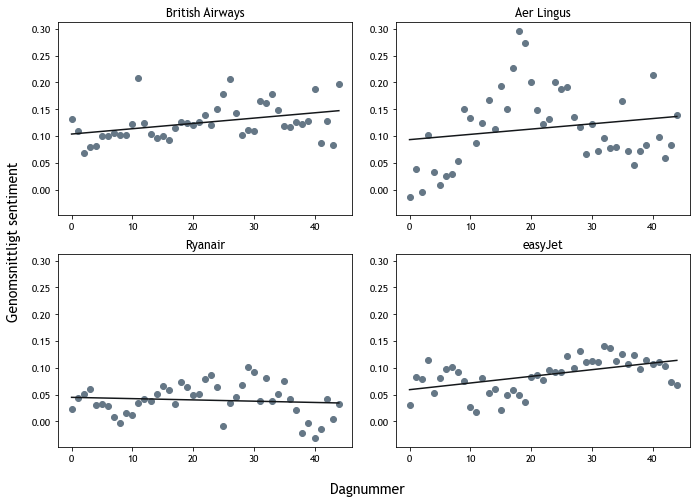

##### Pearson correlation & p-value for day_number and avg_sentiment

,British Airways,Aer Lingus,Ryanair,easyJet
Correlation,0.3839,0.1826,-0.1027,0.5158
p-value,0.0092,0.2299,0.5019,0.0003


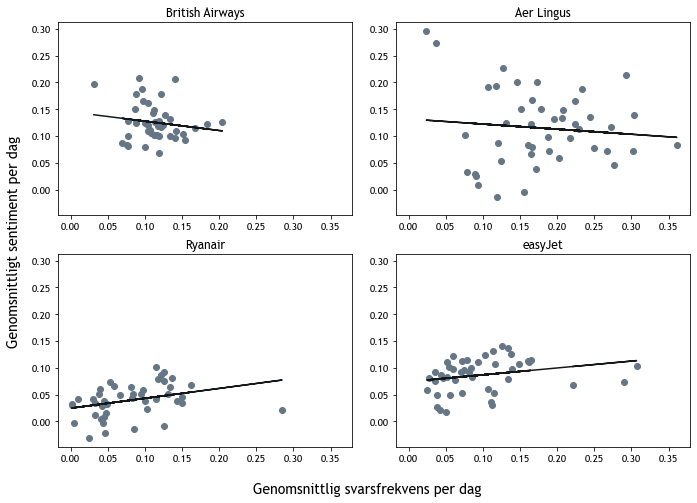

##### Pearson correlation & p-value for reply_freq and avg_sentiment

,British Airways,Aer Lingus,Ryanair,easyJet
Correlation,-0.1576,-0.0995,0.3334,0.2529
p-value,0.3012,0.5153,0.0252,0.0937


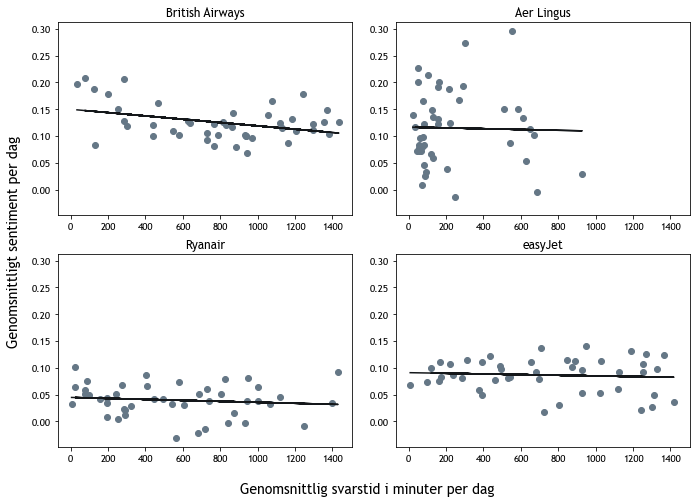

##### Pearson correlation & p-value for avg_reply_time_minutes and avg_sentiment

,British Airways,Aer Lingus,Ryanair,easyJet
Correlation,-0.3636,-0.0245,-0.1173,-0.0798
p-value,0.0141,0.8731,0.4428,0.6025


### Description of the conversation data, early:

##### Tuples = (MIN, MEAN, MAX, STD)

,British Airways,Aer Lingus,Ryanair,easyJet
Conversation starters per day,"(165, 1231.8, 2089, 530.0)","(130, 353.7, 611, 184.8)","(315, 1214.5, 2696, 831.8)","(456, 1109.2, 1737, 425.5)"
Company conv. replys per day,"(22, 140.6, 208, 58.3)","(16, 43.3, 95, 21.9)","(2, 48.6, 120, 41.4)","(24, 81.7, 197, 51.3)"
1-2-3 conversations per day,"(18, 107.1, 156, 41.6)","(13, 32.6, 57, 14.5)","(0, 16.1, 39, 11.9)","(7, 39.6, 73, 20.1)"
Avg. conv. reply time per day (minutes),"(90.6, 696.5, 1205.6, 401.2)","(45.2, 311.0, 707.3, 230.1)","(38.5, 424.9, 1174.9, 363.9)","(174.2, 684.8, 1291.6, 343.6)"
Avg. conv. sentiment change per day,"(0.03, 0.14, 0.25, 0.06)","(-0.09, 0.16, 0.25, 0.09)","(-0.32, 0.16, 0.4, 0.18)","(-0.43, 0.01, 0.28, 0.17)"


### Description of the conversation data, mid:

##### Tuples = (MIN, MEAN, MAX, STD)

,British Airways,Aer Lingus,Ryanair,easyJet
Conversation starters per day,"(370, 694.6, 1135, 209.2)","(77, 192.0, 591, 146.7)","(87, 206.5, 455, 100.0)","(573, 1309.6, 2238, 453.7)"
Company conv. replys per day,"(44, 87.8, 154, 37.4)","(10, 22.9, 33, 7.0)","(8, 21.3, 52, 11.8)","(34, 81.7, 132, 28.4)"
1-2-3 conversations per day,"(36, 74.1, 129, 30.7)","(9, 21.0, 30, 6.8)","(6, 15.5, 32, 7.3)","(8, 34.8, 83, 22.3)"
Avg. conv. reply time per day (minutes),"(34.9, 665.9, 1386.1, 495.9)","(74.2, 260.1, 734.1, 215.2)","(175.6, 544.3, 1159.5, 313.7)","(123.4, 606.3, 1371.3, 406.6)"
Avg. conv. sentiment change per day,"(0.04, 0.13, 0.26, 0.07)","(-0.05, 0.13, 0.39, 0.12)","(-0.07, 0.18, 0.58, 0.18)","(-0.1, 0.1, 0.42, 0.13)"


### Description of the conversation data, late:

##### Tuples = (MIN, MEAN, MAX, STD)

,British Airways,Aer Lingus,Ryanair,easyJet
Conversation starters per day,"(217, 502.9, 759, 194.7)","(33, 68.8, 108, 23.1)","(98, 671.0, 2192, 788.9)","(202, 504.8, 1217, 259.6)"
Company conv. replys per day,"(7, 49.1, 80, 22.7)","(9, 16.7, 39, 7.9)","(2, 42.4, 177, 45.3)","(23, 71.0, 200, 44.9)"
1-2-3 conversations per day,"(7, 40.8, 70, 18.7)","(8, 14.6, 32, 6.4)","(0, 13.3, 31, 8.3)","(19, 57.7, 181, 42.2)"
Avg. conv. reply time per day (minutes),"(22.1, 788.9, 1399.4, 499.5)","(3.2, 56.8, 173.0, 47.5)","(5.2, 560.7, 1402.5, 456.5)","(3.4, 642.3, 1425.6, 470.7)"
Avg. conv. sentiment change per day,"(-0.07, 0.14, 0.28, 0.11)","(-0.12, 0.18, 0.46, 0.16)","(-0.03, 0.17, 0.36, 0.1)","(-0.11, 0.12, 0.2, 0.08)"


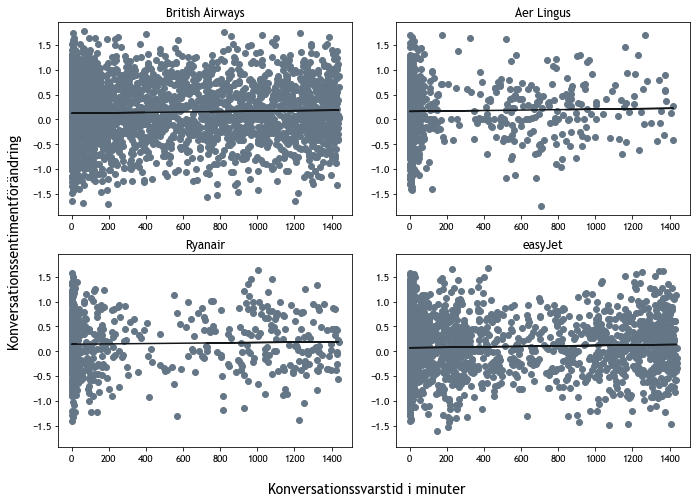

##### Pearson correlation & p-value for answer_time and sentiment_change

,British Airways,Aer Lingus,Ryanair,easyJet
Correlation,0.0347,0.0254,0.0295,0.0422
p-value,0.0451,0.4175,0.4447,0.0603


In [99]:
# Save figures
Path("figures_notitle").mkdir(exist_ok=True)

# Print a general description 
cols = [name for name in results.keys()]
total = [int(general["total_tweets_perday"].sum()) for general in [results[name]["general"] for name in results.keys()]]
user = [int(general["user_tweets_perday"].sum()) for general in [results[name]["general"] for name in results.keys()]]
comp_reply = [int(general["company_replys_perday"].sum()) for general in [results[name]["general"] for name in results.keys()]]

k = "total_tweets_perday"
tweets_perday = [(round(general[k].min(), 0), round(general[k].mean(), 1), round(general[k].max(), 0), round(general[k].std(), 1)) for general in [results[name]["general"] for name in results.keys()]]
k = "user_tweets_perday"
user_perday = [(round(general[k].min(), 0), round(general[k].mean(), 1), round(general[k].max(), 0), round(general[k].std(), 1)) for general in [results[name]["general"] for name in results.keys()]]
k = "company_replys_perday"
replys_perday = [(round(general[k].min(), 0), round(general[k].mean(), 1), round(general[k].max(), 0), round(general[k].std(), 1)) for general in [results[name]["general"] for name in results.keys()]]

k = "avg_reply_time_minutes"
avg_reply = [(round(general[k].min(), 1), round(general[k].mean(), 1), round(general[k].max(), 1), round(general[k].std(), 1)) for general in [results[name]["general"] for name in results.keys()]]
reply_early = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][results[name]["general"].index<DATES[0]] for name in results.keys()]]
reply_mid = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][(results[name]["general"].index>=DATES[0]) & (results[name]["general"].index<DATES[1])] for name in results.keys()]]
reply_late = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][results[name]["general"].index>=DATES[1]] for name in results.keys()]]

k = "reply_freq"
reply_freq = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"] for name in results.keys()]]
freq_early = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][results[name]["general"].index<DATES[0]] for name in results.keys()]]
freq_mid = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][(results[name]["general"].index>=DATES[0]) & (results[name]["general"].index<DATES[1])] for name in results.keys()]]
freq_late = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][results[name]["general"].index>=DATES[1]] for name in results.keys()]]

k = "avg_sentiment"
sentiment = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"] for name in results.keys()]]
sent_early = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][results[name]["general"].index<DATES[0]] for name in results.keys()]]
sent_mid = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][(results[name]["general"].index>=DATES[0]) & (results[name]["general"].index<DATES[1])] for name in results.keys()]]
sent_late = [(round(general[k].min(), 2), round(general[k].mean(), 2), round(general[k].max(), 2), round(general[k].std(), 2)) for general in [results[name]["general"][results[name]["general"].index>=DATES[1]] for name in results.keys()]]


dic = {
    "Total tweets": total,
    "Total user tweets": user,
    "Total company replys": comp_reply,
    "Tweets per day": tweets_perday,
    "User tweets per day": user_perday,
    "Company replys per day": replys_perday,
    "Avg. reply time (minutes) per day": avg_reply,
    "(reply time early)": reply_early,
    "(reply time mid)": reply_mid,
    "(reply time late)": reply_late,
    "Avg. reply frequency per day": reply_freq,
    "(frequency early)": freq_early,
    "(frequency mid)": freq_mid,
    "(frequency late)": freq_late,
    "Avg. user sentiment per day": sentiment,
    "(sentiment early)": sent_early,
    "(sentiment mid)": sent_mid,
    "(sentiment late)": sent_late
}
display(Markdown("### General description of the data:"))
display(Markdown("##### Tuples = (MIN, MEAN, MAX, STD)"))
display(pd.DataFrame.from_dict(dic, orient="index", columns=cols))

# Plot and report correlation & p-values
display(Markdown("### Plots & correlation + p-values"))
for rep in to_report:
    title = rep["title"]
    x_label = rep["x_label"]
    y_label = rep["y_label"]
    result_set = rep["result_set"]
    x_key = rep["x_key"]
    y_key = rep["y_key"]
    plotSubplots(title, x_label, y_label, result_set, x_key, y_key)
    pearson(result_set, x_key, y_key)
    
    #replys	starters	one_two_three	reply_freq	avg_sentiment_change	avg_conv_reply_time_minutes	
# Print description of the conversation data and general data for each period
for period in ["early", "mid", "late"]:
    k = "starters"
    starters_perday = [(round(convs[k].min(), 0), round(convs[k].mean(), 1), round(convs[k].max(), 0), round(convs[k].std(), 1)) for convs in [results[name]["conversations"][period] for name in results.keys()]]
    k = "replys"
    replys_perday = [(round(convs[k].min(), 0), round(convs[k].mean(), 1), round(convs[k].max(), 0), round(convs[k].std(), 1)) for convs in [results[name]["conversations"][period] for name in results.keys()]]
    k = "one_two_three"
    conversations_123 = [(round(convs[k].min(), 0), round(convs[k].mean(), 1), round(convs[k].max(), 0), round(convs[k].std(), 1)) for convs in [results[name]["conversations"][period] for name in results.keys()]]
    k = "avg_conv_reply_time_minutes"
    conv_reply_times = [(round(convs[k].min(), 1), round(convs[k].mean(), 1), round(convs[k].max(), 1), round(convs[k].std(), 1)) for convs in [results[name]["conversations"][period] for name in results.keys()]]
    k = "avg_sentiment_change"
    sentiment_change = [(round(convs[k].min(), 2), round(convs[k].mean(), 2), round(convs[k].max(), 2), round(convs[k].std(), 2)) for convs in [results[name]["conversations"][period] for name in results.keys()]]
    
    
    dic = {
        "Conversation starters per day": starters_perday,
        "Company conv. replys per day": replys_perday,
        "1-2-3 conversations per day": conversations_123,
        "Avg. conv. reply time per day (minutes)": conv_reply_times,
        "Avg. conv. sentiment change per day": sentiment_change
    }
    display(Markdown("### Description of the conversation data, "+period+":"))
    display(Markdown("##### Tuples = (MIN, MEAN, MAX, STD)"))
    display(pd.DataFrame.from_dict(dic, orient="index", columns=cols))
    
for rep in to_report_convs:
    title = rep["title"]
    x_label = rep["x_label"]
    y_label = rep["y_label"]
    result_set = rep["result_set"]
    x_key = rep["x_key"]
    y_key = rep["y_key"]
    plotSubplots(title, x_label, y_label, result_set, x_key, y_key)
    pearson(result_set, x_key, y_key)
    